# Neural tangent kernel, Code reworked from https://rbcborealis.com/research-blogs/neural-tangent-kernel-applications


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from matplotlib import cm
from matplotlib.colors import ListedColormap

Create some data and draw it.

In [14]:
# Input is one dimensional but has ones appended to incorporate biases
X = np.array([[0.2, 0.4, 0.5, 0.55, 0.8],[1,1,1,1,1]])
y = np.array([[0.2], [-0.1], [0.0], [0.01], [-0.1]])

D_in = X.shape[0]   # No of input dimensions (2)
I  = X.shape[1]     # No of data points (3)

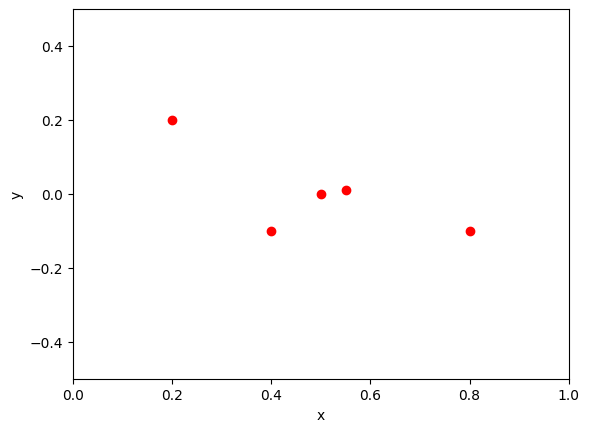

In [15]:
fig, ax  = plt.subplots()
ax.plot(X[0:1,:],y.T,'ro')
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.show()

Support routines to run shallow network and compute derivative of neural network output with respect to network parameters.

In [16]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

# Derivative of ReLU
def ReLUDeriv(z):
  return (z>0).astype(int)

# Shallow network function
def shallow_network(X, omega0, omega1, beta1):
  preactivations = omega0 @ X
  activations = ReLU(preactivations)
  output = beta1 + omega1 @ activations / np.sqrt(omega1.size)
  return output

# Sum of squares loss
def loss(network_output, y):
  return 0.5 * np.mean((network_output-y) * (network_output-y))

Initialize the parameters according to a normal distribution

In [17]:
def initialize_parameters(D, seed=10, D_in = 2):
  # Set the seed so we always get the same numbers
  np.random.seed(seed)

  # Set weights in first layer according to random normal distribution
  # But set last component (which computes biases) to zero
  omega0 = np.random.normal(size=(D, D_in))
  omega0[1,:] = 0
  # Set weights in second layer according to random normal distribution
  omega1 = np.random.normal(size=(1,D))
  # Set bias to zero
  beta1 = 0

  return omega0, omega1, beta1

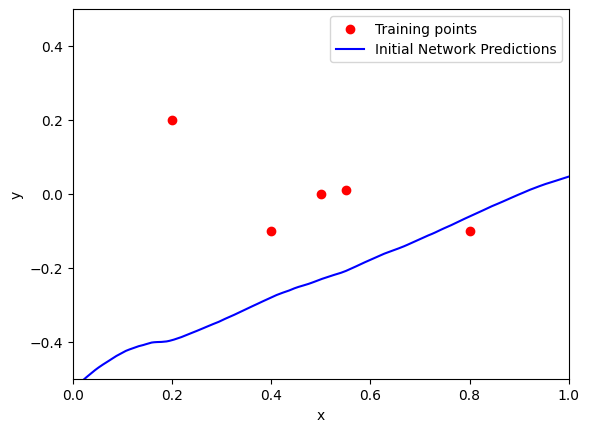

In [18]:
# Define an array of points where will make new predictions
x_vals = np.arange(0,1,0.001)[None,:]
x_vals = np.concatenate((x_vals, np.ones_like(x_vals)))
# Number of hidden units
D = 10000
# Random seed for initialized parameters
seed = 1
# Number of input dimension (2 as have appended a 1 to incorporate first layer biases)
D_in = 2

# Initialize the parameters
omega0, omega1, beta1 = initialize_parameters(D, seed = seed, D_in=D_in)


fig, ax  = plt.subplots()
ax.scatter(X[0,:], y.T, color='r', marker='o', label='Training points')  # Using ax.scatter
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.plot(x_vals[0:1,:].T, shallow_network(x_vals, omega0, omega1, beta1).T,'b-',label='Initial Network Predictions')
ax.legend()
plt.show()


Iteration 2, Loss: 0.011915909046890837
Iteration 20, Loss: 0.006686437073595759
Iteration 100, Loss: 0.008195220697086286
Iteration 500, Loss: 0.01013118379931387
Iteration 1000, Loss: 0.010927429520375153


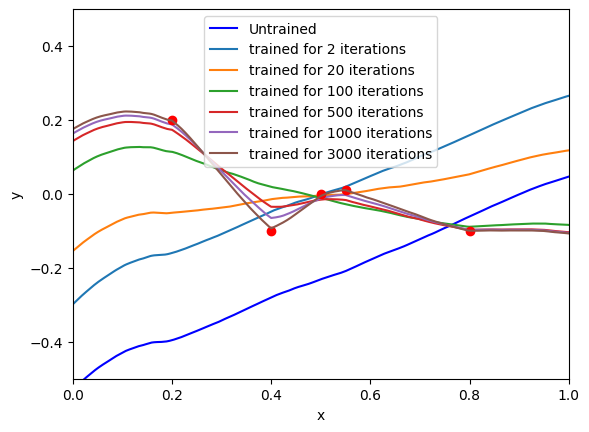

In [19]:
# prompt: write code that uses gradient descent to train the shallow network

# Learning rate
learning_rate = 0.1

# Number of iterations
n_iterations = 3000
fig, ax  = plt.subplots()
ax.plot(x_vals[0:1,:].T, shallow_network(x_vals, omega0, omega1, beta1).T,'b-',label='Untrained')


# Gradient descent
for i in range(n_iterations):
  # Forward pass
  preactivations = omega0 @ X
  activations = ReLU(preactivations)
  output = beta1 + omega1 @ activations / np.sqrt(omega1.size)

  # Compute the loss
  loss_val = loss(output, y)

  # Backward pass
  d_loss_d_output = (output.T - y).T
  d_output_d_omega1 = activations / np.sqrt(omega1.size)
  d_loss_d_omega1 = d_loss_d_output @ d_output_d_omega1.T
  d_loss_d_beta1 = np.sum(d_loss_d_output)

  d_output_d_activations = omega1 / np.sqrt(omega1.size)
  d_activations_d_preactivations = ReLUDeriv(preactivations)
  d_preactivations_d_omega0 = X
  first = d_loss_d_output.T @ d_output_d_activations
  second = first * d_activations_d_preactivations.T
  d_loss_d_omega0 = second.T @ d_preactivations_d_omega0.T

  # Update parameters
  omega1 = omega1 - learning_rate * d_loss_d_omega1
  beta1 = beta1 - learning_rate * d_loss_d_beta1
  omega0 = omega0 - learning_rate * d_loss_d_omega0

  # Print the loss every 100 iterations
  if i == 2 or i == 20 or i == 100 or i  == 500 or i == 1000:
    print(f"Iteration {i}, Loss: {loss_val}")
    ax.plot(x_vals[0:1,:].T, shallow_network(x_vals, omega0, omega1, beta1).T,label=f'trained for {i} iterations')



# Plot the results
ax.plot(X[0:1,:],y.T,'ro')
ax.plot(x_vals[0:1,:].T, shallow_network(x_vals, omega0, omega1, beta1).T,label=f'trained for {n_iterations} iterations')
NN_preds = shallow_network(x_vals, omega0, omega1, beta1)

ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.legend()
plt.show()


In [20]:
# Define an array of points where will make new predictions
x_vals = np.arange(0,1,0.001)[None,:]
x_vals = np.concatenate((x_vals, np.ones_like(x_vals)))
# Number of hidden units
D = 10000
# Random seed for initialized parameters
seed = 1
# Number of input dimension (2 as have appended a 1 to incorporate first layer biases)
D_in = 2

# Initialize the parameters
omega0, omega1, beta1 = initialize_parameters(D, seed = seed, D_in=D_in)


Routines to calculate the empirical and analytical NTK (i.e. the NTK with infinite hidden units) for the shallow network

In [21]:
# Compute the empirical NTK for the shallow network
def compute_empirical_ntk(X1,X2, omega0, omega1, beta1):

  I1 = X1.shape[1]
  I2 = X2.shape[1]
  K = np.zeros((I1,I2))
  preactivations1 = omega0 @ X1
  preactivations2 = omega0 @ X2

  for i in range(I1):
    for j in range(I2):
        K[i,j] = np.mean(ReLU(preactivations1[:,i]) * ReLU(preactivations2[:,j])) + 1
        K[i,j] = K[i,j] + X1[:,i] @ X2[:,j].T * np.mean(omega1 * omega1 * ReLUDeriv(preactivations1[:,i]) * ReLUDeriv(preactivations2[:,j]))
  return K

# Compute theoretical NTK for the shallow network
def compute_analytical_ntk(X1, X2):
  I1 = X1.shape[1]
  I2 = X2.shape[1]
  K = np.zeros((I1,I2))

  for i in range(I1):
    for j in range(I2):
        x1 = X1[:,i]
        x2 = X2[:,j]
        norm1 = np.sqrt(x1.T@x1)
        norm2 = np.sqrt(x2.T@x2)
        if norm1==0 or norm2 ==0:
          theta = 0
        else:
          try:
            theta = np.arccos(x1.T@x2/(norm1*norm2))
          except:
            theta = 0
        K[i,j] = x1.T@x2 * (np.pi-theta)/(2*np.pi)
        K[i,j] = K[i,j] + norm1 * norm2 * ((np.pi-theta)*np.cos(theta)+np.sin(theta))/(2*np.pi)  + 1
  return K

Compute empirical and analytical NTK for wide network with 10,000 hidden units and show they are almost the same

In [22]:


# Compute empirical and analytical NTKs
# When D is large, they should be similar
K = compute_empirical_ntk(X, X, omega0, omega1, beta1)
print("Empirical NTK\n", K)
K_analytical = compute_analytical_ntk(X,X)
print("\nAnalytical NTK\n", K_analytical)

Empirical NTK
 [[2.04085309 2.05056274 2.0553445  2.05873331 2.07678583]
 [2.05056274 2.16579802 2.18941212 2.20193704 2.26270065]
 [2.0553445  2.18941212 2.25763324 2.27512708 2.35925063]
 [2.05873331 2.20193704 2.27512708 2.312816   2.40915681]
 [2.07678583 2.26270065 2.35925063 2.40915681 2.64972495]]

Analytical NTK
 [[2.04       2.04888213 2.05452076 2.05778225 2.07923821]
 [2.04888213 2.16       2.18415788 2.19636519 2.26003372]
 [2.05452076 2.18415788 2.25       2.2670504  2.35367615]
 [2.05778225 2.19636519 2.2670504  2.3025     2.40099662]
 [2.07923821 2.26003372 2.35367615 2.40099662 2.64      ]]


Compute Jacobian containing derivatives of network output with respect to network parameters for each input

In [23]:
# Get vector of derivatives of network output with respect to parameters
# omega0, omega1, beta1
# There are no offsets beta0 as they are incorporated by concatenating ones to each input
def derivative_vector(x,omega0, omega1, beta1):
  preactivations = omega0 @ x
  activations = ReLU(preactivations)
  D = omega1.size

  dfdomega0 = ( np.ones((omega0.size,1)) @ ReLUDeriv(activations).T ) * np.concatenate((np.identity(D) * x[0,:],np.identity(D) * x[1,:]),axis=0) @ omega1.T / np.sqrt(D)
  dfdbeta1 = np.ones((1,1))
  dfdomega1 = activations / np.sqrt(D)

  return np.concatenate((dfdomega0, dfdbeta1, dfdomega1), axis=0)

# Compute Jacobian of how network outputs change for each point given change in parameters
def get_jacobian(X, omega0, omega1, beta1):
    n_param = omega0.size+omega1.size+1
    n_data = X.shape[1]
    jacobian = np.zeros((n_param, n_data))
    for i in range (n_data):
      jacobian[:,i:i+1] = derivative_vector(X[:,i:i+1], omega0, omega1, beta1)
    return jacobian

Confirm that emprical NTK is just the product of the Jacobians

In [24]:
K = compute_empirical_ntk(X, X, omega0, omega1, beta1)
print("Empirical NTK\n", K)
K_from_jacobian = get_jacobian(X, omega0, omega1, beta1).T @ get_jacobian(X, omega0, omega1, beta1)
print("NTK from Jacobian\n", K_from_jacobian)

Empirical NTK
 [[2.04085309 2.05056274 2.0553445  2.05873331 2.07678583]
 [2.05056274 2.16579802 2.18941212 2.20193704 2.26270065]
 [2.0553445  2.18941212 2.25763324 2.27512708 2.35925063]
 [2.05873331 2.20193704 2.27512708 2.312816   2.40915681]
 [2.07678583 2.26270065 2.35925063 2.40915681 2.64972495]]
NTK from Jacobian
 [[2.04085309 2.05056274 2.0553445  2.05873331 2.07678583]
 [2.05056274 2.16579802 2.18941212 2.20193704 2.26270065]
 [2.0553445  2.18941212 2.25763324 2.27512708 2.35925063]
 [2.05873331 2.20193704 2.27512708 2.312816   2.40915681]
 [2.07678583 2.26270065 2.35925063 2.40915681 2.64972495]]


[[2.04085309 2.05056274 2.0553445  2.05873331 2.07678583]
 [2.05056274 2.16579802 2.18941212 2.20193704 2.26270065]
 [2.0553445  2.18941212 2.25763324 2.27512708 2.35925063]
 [2.05873331 2.20193704 2.27512708 2.312816   2.40915681]
 [2.07678583 2.26270065 2.35925063 2.40915681 2.64972495]]
[[ 3.56090002]
 [-7.23971186]
 [ 2.3848648 ]
 [ 1.8869146 ]
 [-0.48544393]]
[[1.96886036 1.94284345 1.93139425 1.92694764 1.90879252]
 [1.9693706  1.9435184  1.9321434  1.9277325  1.90974102]
 [1.96955521 1.94386779 1.93256701 1.92819182 1.91036406]
 ...
 [2.10161988 2.31946567 2.4335606  2.49266264 2.7809019 ]
 [2.10179149 2.31980092 2.43398568 2.49313479 2.78161796]
 [2.10201874 2.32020103 2.43448024 2.49367873 2.78241736]]


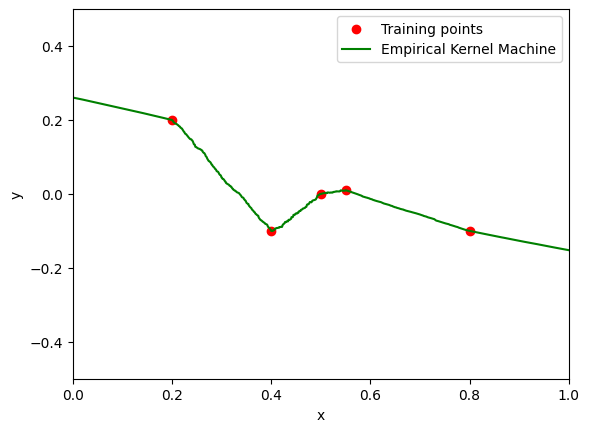

In [25]:
K_pred = compute_empirical_ntk(X, X, omega0, omega1, beta1)
print(K_pred)
alpha = np.linalg.inv(K_pred)@y # + np.identity(I)*0.001
print(alpha)
K_test = compute_empirical_ntk(x_vals, X, omega0, omega1, beta1)
print(K_test)
y_pred = K_test @ alpha
fig, ax  = plt.subplots()
ax.scatter(X[0,:], y.T, color='r', marker='o', label='Training points')  # Using ax.scatter
K_emperical_preds = y_pred
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.plot(x_vals[0,:],y_pred[:], 'g',  label = "Empirical Kernel Machine")
ax.legend()
plt.show()

[[2.04       2.04888213 2.05452076 2.05778225 2.07923821]
 [2.04888213 2.16       2.18415788 2.19636519 2.26003372]
 [2.05452076 2.18415788 2.25       2.2670504  2.35367615]
 [2.05778225 2.19636519 2.2670504  2.3025     2.40099662]
 [2.07923821 2.26003372 2.35367615 2.40099662 2.64      ]]
[[ 3.71227417]
 [-7.69875482]
 [ 2.55917859]
 [ 2.04609135]
 [-0.51340637]]
[[1.96899803 1.94254304 1.93199385 1.92747525 1.91254724]
 [1.96934468 1.94305387 1.93257938 1.92809655 1.91333483]
 [1.96969146 1.94356496 1.93316522 1.9287182  1.91412293]
 ...
 [2.10233187 2.31420556 2.42484561 2.480974   2.76649572]
 [2.10246229 2.3144901  2.42521463 2.48138682 2.76714014]
 [2.10259283 2.31477475 2.42558372 2.48179971 2.76778459]]


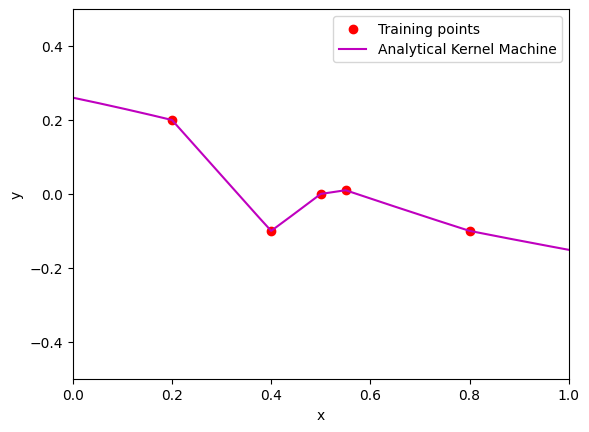

In [26]:
K_pred = compute_analytical_ntk(X, X)
print(K_pred)
alpha = np.linalg.inv(K_pred)@y # + np.identity(I)*0.001
print(alpha)
K_test = compute_analytical_ntk(x_vals, X)
print(K_test)
y_pred = K_test @ alpha
K_analytical_preds = y_pred
fig, ax  = plt.subplots()
ax.scatter(X[0,:], y.T, color='r', marker='o', label='Training points')  # Using ax.scatter
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.plot(x_vals[0,:],y_pred[:],'m', label = "Analytical Kernel Machine")
ax.legend()
plt.show()

In [27]:
rkhs_norm = np.sqrt(alpha.T @ K_analytical @ alpha)

print("RKHS Norm:", rkhs_norm)


RKHS Norm: [[1.258623]]


In [28]:
# prompt: calculate the norm of the parameters in the network (omega and bias)

omega_norm = np.linalg.norm(omega0[:,0]/np.sqrt(D)) + np.linalg.norm(omega1/np.sqrt(D))
bias_norm = np.linalg.norm(beta1)

print("Norm of omega:", omega_norm)
print("Norm of bias:", bias_norm)


Norm of omega: 2.001510584980764
Norm of bias: 0.0


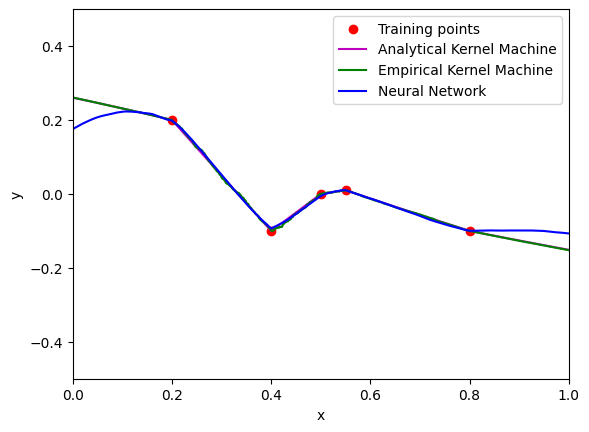

In [29]:
fig, ax  = plt.subplots()
ax.scatter(X[0,:], y.T, color='r', marker='o', label='Training points')  # Using ax.scatter
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.plot(x_vals[0,:],K_analytical_preds[:], 'm',label = "Analytical Kernel Machine")
plt.plot(x_vals[0,:],K_emperical_preds[:], 'g', label = "Empirical Kernel Machine")
plt.plot(x_vals[0,:],NN_preds[0], 'b', label = "Neural Network")
ax.legend()
plt.show()


Compute prediction at training points, residuals, and parameters as a function of time during training process

In [30]:
# Define time steps and count them
t_all = np.arange(0,100,0.05)
nT = t_all.shape[0]
# Create array for predictions at training data points as a function of time
f_all = np.zeros((I,nT))
# Create array for residuals at training data points as a function of time
residuals_all = np.zeros((I,nT))
# Create array for 3D+1 parameters as a function of time
phi_t_all = np.zeros((3*D+1,nT))

# Precompute the Moore Penrose inverse
moore_penrose_inverse = get_jacobian(X, omega0, omega1, beta1) @ (np.linalg.inv(K))
# Store the initial vectors in a vector
phi_0 = np.concatenate((omega0[:,0:1],omega0[:,1:2],np.ones((1,1))*beta1,omega1.T))
# Compute initial network outputs at training points
f_0 = shallow_network(X, omega0, omega1, beta1).T

# For each time step
for t in range(len(t_all)):
  # Compute prediction at data points
  f_all[:,t:t+1] = y + expm(-K * t_all[t]) @ (f_0-y)
  # Compute residuals at data points
  residuals_all[:,t:t+1] = f_all[:,t:t+1]-y
  # Compute parameter vector
  phi_t_all[:,t:t+1] = phi_0 - moore_penrose_inverse @ (np.identity(I)-expm(-K * t_all[t])) @ (f_0-y)

Draw predictions at data points over time

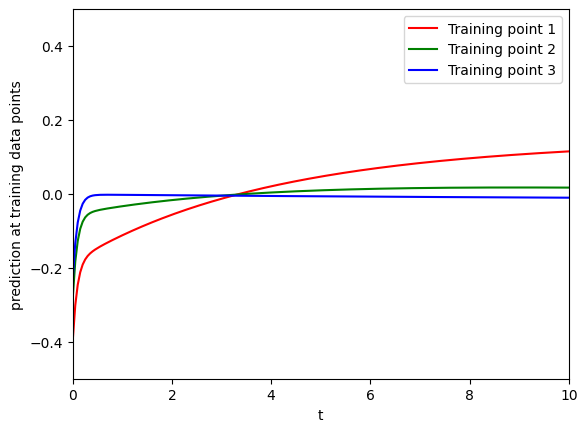

In [31]:
fig, ax  = plt.subplots()
ax.plot(t_all,np.squeeze(f_all[0,:]),'r-', label='Training point 1')
ax.plot(t_all,np.squeeze(f_all[1,:]),'g-', label='Training point 2')
ax.plot(t_all,np.squeeze(f_all[2,:]),'b-', label='Training point 3')
ax.set_xlim([0,10]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('t'); ax.set_ylabel('prediction at training data points')
ax.legend()
plt.show()

Plot residuals as a function of time

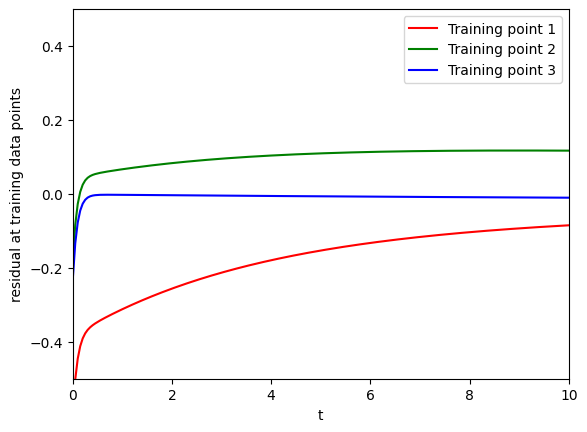

In [32]:
fig, ax  = plt.subplots()
ax.plot(t_all,np.squeeze(residuals_all[0,:]),'r-', label='Training point 1')
ax.plot(t_all,np.squeeze(residuals_all[1,:]),'g-', label='Training point 2')
ax.plot(t_all,np.squeeze(residuals_all[2,:]),'b-', label='Training point 3')
ax.set_xlim([0,10]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('t'); ax.set_ylabel('residual at training data points')
ax.legend()
plt.show()

Plot loss as a function of time

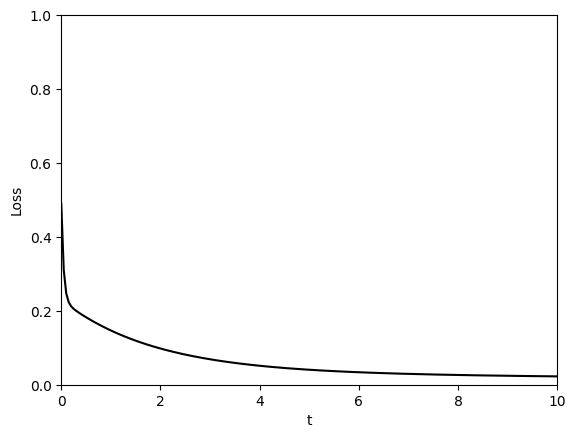

In [33]:
fig, ax  = plt.subplots()
square_error = np.sum(residuals_all * residuals_all, axis=0)
ax.plot(t_all, square_error,'k-')
ax.set_xlim([0,10]); ax.set_ylim([-0.0,1.0])
ax.set_xlabel('t'); ax.set_ylabel('Loss')
plt.show()

Plot parameters as a function of time (almost constant with large width)

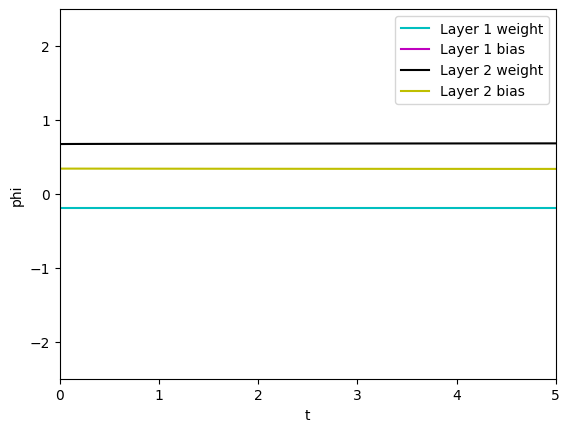

In [34]:
fig, ax  = plt.subplots()
ax.plot(t_all, np.squeeze(phi_t_all[20,:]),'c-', label='Layer 1 weight')
ax.plot(t_all, np.squeeze(phi_t_all[15250,:]),'m-', label = 'Layer 1 bias')
ax.plot(t_all, np.squeeze(phi_t_all[20305,:]),'k-', label = 'Layer 2 weight')
ax.plot(t_all, np.squeeze(phi_t_all[30000,:]),'y-', label = 'Layer 2 bias')
ax.set_xlim([0,5]); ax.set_ylim([-2.5,2.5])
ax.set_xlabel('t'); ax.set_ylabel('phi')
ax.legend()
plt.show()

Helper routines to run network using parameter vector directly

In [35]:
def vector_to_params(params):
    D = int((params.size-1)/3)
    omega0 = np.ones((D,2))
    omega0[:,0:1] = params[0:D,0:1]
    omega0[:,1:2] = params[D:D*2,0:1]
    beta1 = params[D*2:D*2+1,0:1]
    omega1 = params[D*2+1:D*3+1,0:1].T
    return omega0, omega1, beta1

def shallow_network_param_vector(X, phi):
    omega0, omega1, beta1 = vector_to_params(phi)
    return shallow_network(X,omega0,omega1,beta1)

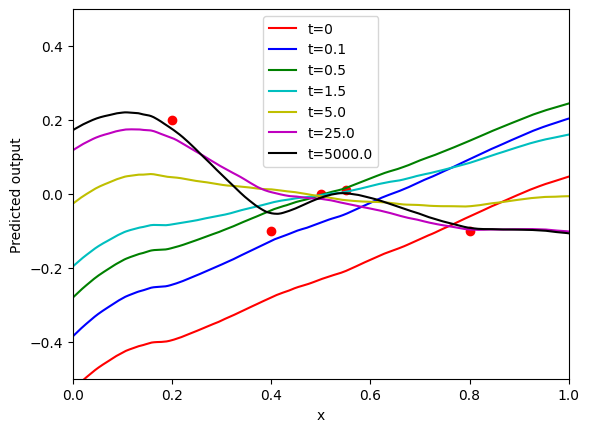

In [36]:
# Define an array of points where will make new predictions
x_vals = np.arange(0,1,0.001)[None,:]
x_vals = np.concatenate((x_vals, np.ones_like(x_vals)))

# Compute parameters at 6 different time points
phi_1 = phi_0 - moore_penrose_inverse @ (np.identity(I)-expm(-K * 0.1)) @ (f_0-y)
phi_2 = phi_0 - moore_penrose_inverse @ (np.identity(I)-expm(-K * 0.5)) @ (f_0-y)
phi_3 = phi_0 - moore_penrose_inverse @ (np.identity(I)-expm(-K * 1.5)) @ (f_0-y)
phi_4 = phi_0 - moore_penrose_inverse @ (np.identity(I)-expm(-K * 5.0)) @ (f_0-y)
phi_5 = phi_0 - moore_penrose_inverse @ (np.identity(I)-expm(-K * 25.0)) @ (f_0-y)
phi_6 = phi_0 - moore_penrose_inverse @ (np.identity(I)-expm(-K * 5000.0)) @ (f_0-y)

# Draw the function evolution over time
fig, ax  = plt.subplots()
ax.plot(X[0:1,:],y.T,'ro')
ax.plot(x_vals[0:1,:].T, shallow_network_param_vector(x_vals, phi_0).T,'r-',label='t=0')
ax.plot(x_vals[0:1,:].T, shallow_network_param_vector(x_vals, phi_1).T,'b-',label='t=0.1')
ax.plot(x_vals[0:1,:].T, shallow_network_param_vector(x_vals, phi_2).T,'g-',label='t=0.5')
ax.plot(x_vals[0:1,:].T, shallow_network_param_vector(x_vals, phi_3).T,'c-',label='t=1.5')
ax.plot(x_vals[0:1,:].T, shallow_network_param_vector(x_vals, phi_4).T,'y-',label='t=5.0')
ax.plot(x_vals[0:1,:].T, shallow_network_param_vector(x_vals, phi_5).T,'m-',label='t=25.0')
ax.plot(x_vals[0:1,:].T, shallow_network_param_vector(x_vals, phi_6).T,'k-',label='t=5000.0')
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('Predicted output')
ax.legend()
plt.show()

The previous way of making predictions used the full non-linear model.  Here, we make predictions using the empirical kernel

In [37]:
 # Make predictions directly using kernel method (linear approximation)
def kernel_predict_empirical(X,x,y,t, f_0, omega0, omega1, beta1):
  K = compute_empirical_ntk(X,X, omega0, omega1, beta1)
  predict = compute_empirical_ntk(x,X, omega0, omega1, beta1) @ np.linalg.inv(K) @ (np.identity(I)-expm(-K * t)) @ (f_0-y)
  return predict


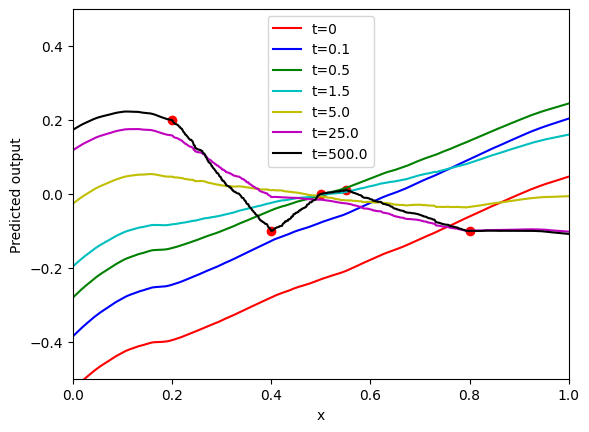

In [47]:
# Get predictions at time 0
f_0_x = shallow_network_param_vector(x_vals, phi_0).T
# Get predictions at six different time points
f_0_test = f_0_x - kernel_predict_empirical(X, x_vals, y, 0.0, f_0, omega0, omega1, beta1)
f_1_test = f_0_x - kernel_predict_empirical(X, x_vals, y, 0.1, f_0, omega0, omega1, beta1)
f_2_test = f_0_x - kernel_predict_empirical(X, x_vals, y, 0.5, f_0, omega0, omega1, beta1)
f_3_test = f_0_x - kernel_predict_empirical(X, x_vals, y, 1.5, f_0, omega0, omega1, beta1)
f_4_test = f_0_x - kernel_predict_empirical(X, x_vals, y, 5.0, f_0, omega0, omega1, beta1)
f_5_test = f_0_x - kernel_predict_empirical(X, x_vals, y, 25.0, f_0, omega0, omega1, beta1)
f_6_test = f_0_x - kernel_predict_empirical(X, x_vals, y, 500.0, f_0, omega0, omega1, beta1)
trained_empirical = f_6_test

fig, ax  = plt.subplots()
ax.plot(X[0:1,:],y.T,'ro')
ax.plot(x_vals[0:1,:].T, f_0_test,'r-',label='t=0')
ax.plot(x_vals[0:1,:].T, f_1_test,'b-',label='t=0.1')
ax.plot(x_vals[0:1,:].T, f_2_test,'g-',label='t=0.5')
ax.plot(x_vals[0:1,:].T, f_3_test,'c-',label='t=1.5')
ax.plot(x_vals[0:1,:].T, f_4_test,'y-',label='t=5.0')
ax.plot(x_vals[0:1,:].T, f_5_test,'m-',label='t=25.0')
ax.plot(x_vals[0:1,:].T, f_6_test,'k-',label='t=500.0')
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('Predicted output')
ax.legend()
plt.show()

Now let's do the same thing with the analytical kernel (i.e. with an infinitely wide network)

In [39]:
def kernel_predict_analytical(X,x,y,t, f_0):
  K = compute_analytical_ntk(X,X)
  predict = compute_analytical_ntk(x,X) @ np.linalg.inv(K) @ (np.identity(I)-expm(-K * t)) @ (f_0-y)
  return predict

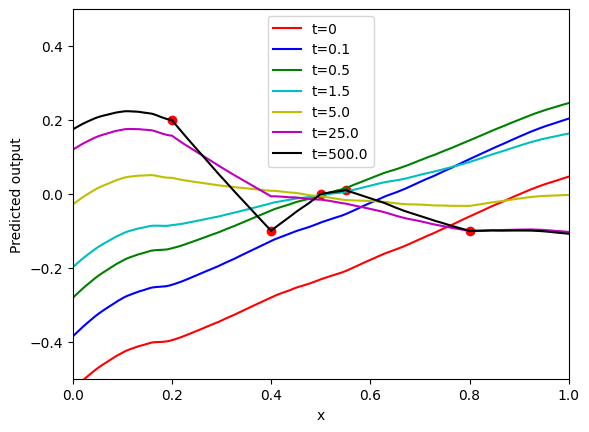

In [48]:
# Get predictions at time 0
f_0_x = shallow_network_param_vector(x_vals, phi_0).T
# Get predictions at six different time points
f_0_test = f_0_x - kernel_predict_analytical(X, x_vals, y, 0.0, f_0)
f_1_test = f_0_x - kernel_predict_analytical(X, x_vals, y, 0.1, f_0)
f_2_test = f_0_x - kernel_predict_analytical(X, x_vals, y, 0.5, f_0)
f_3_test = f_0_x - kernel_predict_analytical(X, x_vals, y, 1.5, f_0)
f_4_test = f_0_x - kernel_predict_analytical(X, x_vals, y, 5.0, f_0)
f_5_test = f_0_x - kernel_predict_analytical(X, x_vals, y, 25.0, f_0)
f_6_test = f_0_x - kernel_predict_analytical(X, x_vals, y, 500.0, f_0)
trained_analytical = f_6_test


fig, ax  = plt.subplots()
ax.plot(X[0:1,:],y.T,'ro')
ax.plot(x_vals[0:1,:].T, f_0_test,'r-',label='t=0')
ax.plot(x_vals[0:1,:].T, f_1_test,'b-',label='t=0.1')
ax.plot(x_vals[0:1,:].T, f_2_test,'g-',label='t=0.5')
ax.plot(x_vals[0:1,:].T, f_3_test,'c-',label='t=1.5')
ax.plot(x_vals[0:1,:].T, f_4_test,'y-',label='t=5.0')
ax.plot(x_vals[0:1,:].T, f_5_test,'m-',label='t=25.0')
ax.plot(x_vals[0:1,:].T, f_6_test,'k-',label='t=500.0')
ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('Predicted output')
ax.legend()
plt.show()

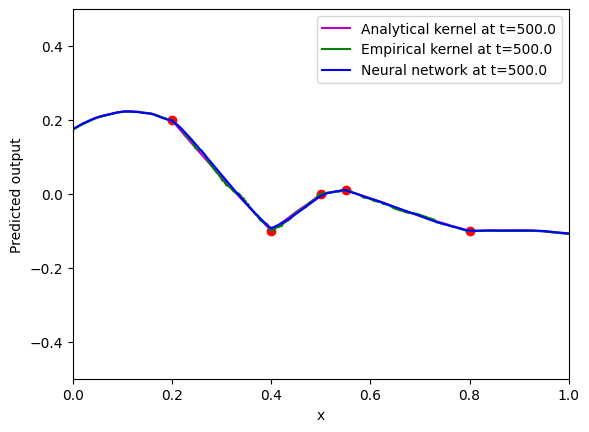

In [50]:
fig, ax  = plt.subplots()
ax.plot(X[0:1,:],y.T,'ro')
ax.plot(x_vals[0:1,:].T, trained_analytical,'m',label='Analytical kernel at t=500.0')
ax.plot(x_vals[0:1,:].T, trained_empirical,'g',label='Empirical kernel at t=500.0')
ax.plot(x_vals[0:1,:].T, NN_preds[0],'b',label='Neural network at t=500.0')

ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x'); ax.set_ylabel('Predicted output')
ax.legend()
plt.show()

Compute the mean prediction and uncertainty at a given time

In [51]:
# Compute initial covariance
def compute_cov_init(X1, X2, sigma_sq_p=2.0):
  I1 = X1.shape[1]
  I2 = X2.shape[1]
  K = np.zeros((I1,I2))

  for i in range(I1):
    for j in range(I2):
        x1 = X1[:,i]
        x2 = X2[:,j]
        norm1 = np.sqrt(x1.T@x1)
        norm2 = np.sqrt(x2.T@x2)
        if norm1 < 1e-10 or norm2 < 1e-10:
          theta = 0
        else:
          if np.array_equal(x1,x2):
            theta = 0
          else:
            theta = np.arccos(x1.T@x2/(norm1*norm2))
        K[i,j] = sigma_sq_p * norm1 * norm2 * ((np.pi-theta)*np.cos(theta)+np.sin(theta))/(2*np.pi)  + 1
  return K

# Equations 14 and 15 from Lee et al. (2019)
def kernel_predict_uncertainty(X,x,y,t, sigma_sq_n=0.001):
  NTKXX = compute_analytical_ntk(X, X)
  NTKxX = compute_analytical_ntk(x, X)

  f_0_xx_cov = compute_cov_init(x,x)
  f_0_XX_cov = compute_cov_init(X,X)
  f_0_Xx_cov = compute_cov_init(X,x)
  Z = NTKxX @ np.linalg.inv(NTKXX) @ (np.identity(I)-expm(-K * t))

  mean =Z @ y
  cov = f_0_xx_cov +  Z @ f_0_XX_cov @ Z.T -2 * Z @ f_0_Xx_cov
  return mean, np.sqrt(np.diag(cov+np.identity(cov.shape[0])*sigma_sq_n))[:,None]

Draw function with uncertainty at a number of different time points

Time, t=0.000


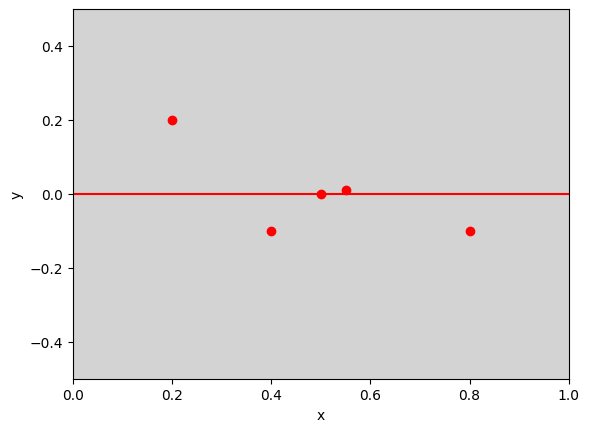

Time, t=0.100


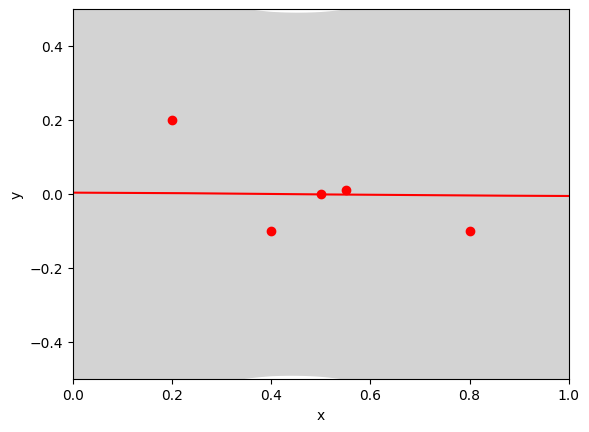

Time, t=0.500


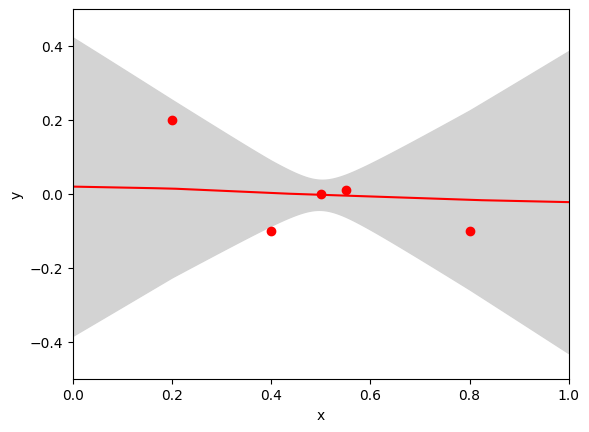

Time, t=1.500


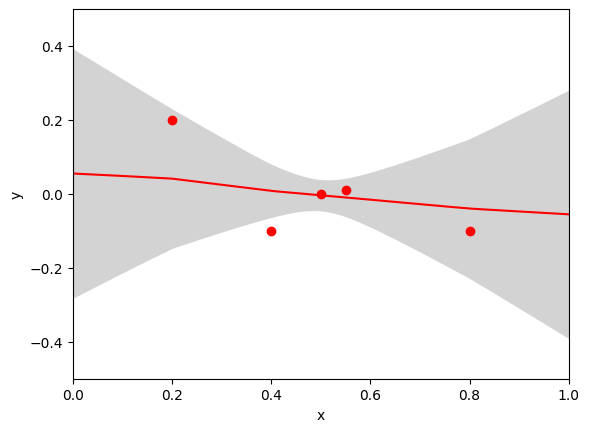

Time, t=5.000


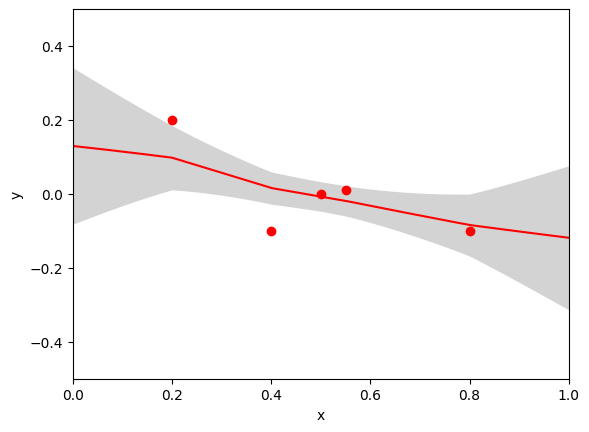

Time, t=25.000


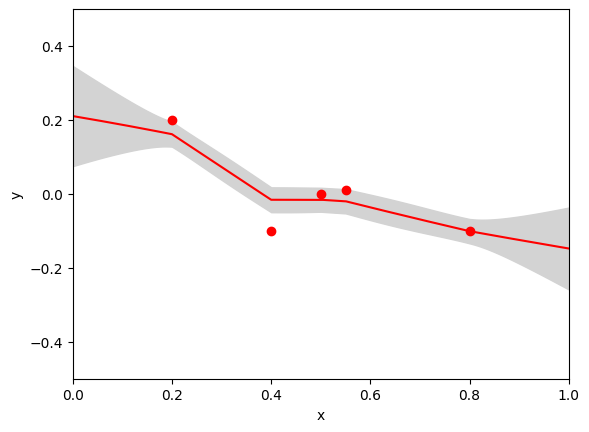

Time, t=500.000


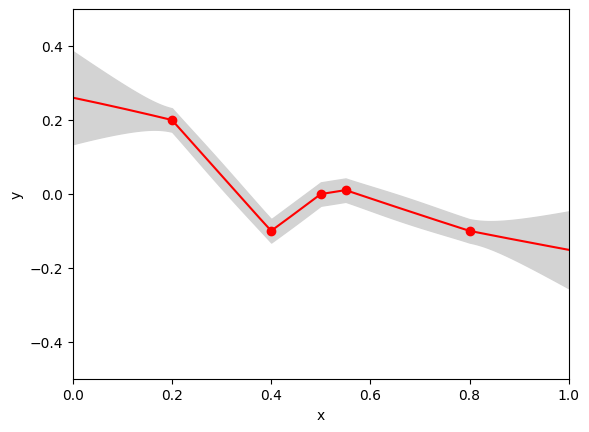

In [52]:
def draw_func_uncertain(X, y, x ,predict_mean, predict_std, t):
  fig, ax  = plt.subplots()
  ax.plot(X[0:1,:],y.T,'ro')
  ax.plot(x[0:1,:].T, predict_mean,'r-')
  lower = predict_mean-predict_std
  upper = predict_mean+predict_std
  ax.fill_between(np.squeeze(x[0:1,:].T), np.squeeze(lower), np.squeeze(upper), color='lightgray')
  ax.set_xlim([0,1]); ax.set_ylim([-0.5,0.5])
  ax.set_xlabel('x'); ax.set_ylabel('y')
  plt.show()

for t in (0.0, 0.1, 0.5,1.5,5.0,25.0,500.0):
  print('Time, t=%3.3f'%(t))
  f_mean, f_std = kernel_predict_uncertainty(X, x_vals, y, t)
  draw_func_uncertain(X, y, x_vals, f_mean, f_std, t)

Draw the kernel

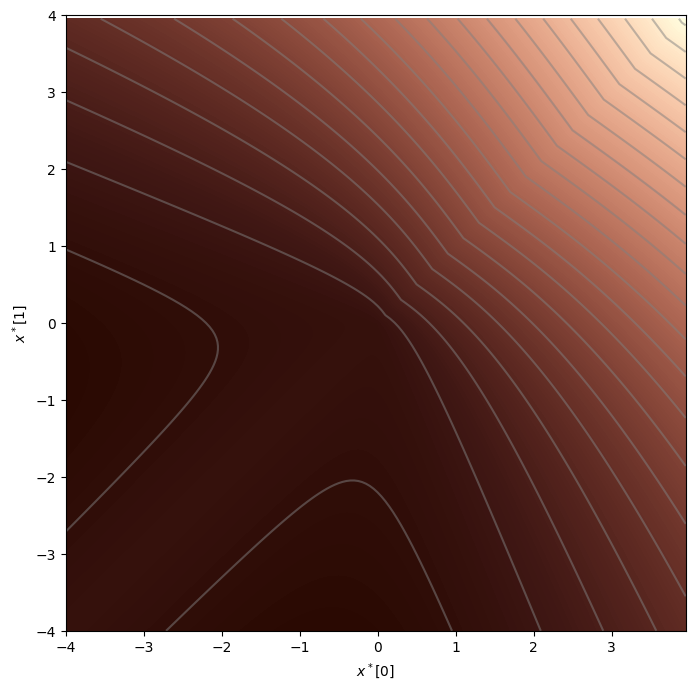

In [53]:
def draw_kernel(X1):
  # Define pretty colormap
  my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
  my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
  r = np.floor(my_colormap_vals_dec/(256*256))
  g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
  b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
  my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

  # Make grid of intercept/slope values to plot
  x_mesh, y_mesh = np.meshgrid(np.arange(-4,4,0.05), np.arange(-4,4,0.05))
  kernel_mesh = np.zeros_like(x_mesh)

  for idx, x in np.ndenumerate(x_mesh):
      X2 = np.ones((2,1))
      X2[0,0] = x+0.0001
      X2[1,0] = y_mesh[idx]+0.0001
      kernel_mesh[idx] = compute_analytical_ntk(X1, X2)[0,0]

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contour(x_mesh,y_mesh,kernel_mesh,20,colors=['#80808080'])
  ax.contourf(x_mesh,y_mesh,kernel_mesh,256,cmap=my_colormap)
  ax.set_ylim([-4,4])
  ax.set_xlabel('$x^*[0]$')
  ax.set_ylabel('$x^*[1]$')

  plt.show()

# Draw kernel for X1 = 1.0
X1 = np.ones((2,1))
X1[0,0] = 1.000000
draw_kernel(X1)